In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import cbsodata # CBS Open Data Python package of Statistiek Netherlands
import matplotlib.pyplot as plt

In [5]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'helvetica'

In [7]:
# Retrieve the municipal boundaries map from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
gemeentegrenzen = gpd.read_file(geodata_url)

Source https://stackoverflow.com/questions/63516948/how-to-convert-shapefile-geojson-to-hexagons-using-uber-h3-in-python

In [9]:
import h3pandas
import h3

In [11]:
gemeentegrenzen_c=gemeentegrenzen.to_crs('epsg:4326').h3.polyfill(7, explode=True)
gemeentegrenzen_c=gemeentegrenzen_c.dropna(subset=['h3_polyfill'])
gdf_h3 = gemeentegrenzen_c.set_index('h3_polyfill').h3.h3_to_geo_boundary()

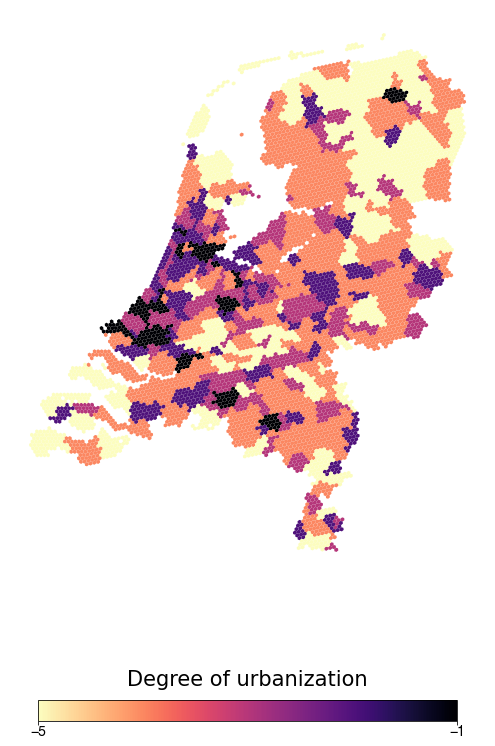

In [12]:
# Try with other measures

identifier = "83765NED"
var_plot= "MateVanStedelijkheid_104"
resolution=7
color_map='magma_r'

# Download birth rates and remove spaces from region codes
data = pd.DataFrame(cbsodata.get_data(identifier, select = ['WijkenEnBuurten', 'Codering_3', var_plot]))
data['Codering_3'] = data['Codering_3'].str.strip()

# Retrieve the municipal boundaries map from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
gemeentegrenzen = gpd.read_file(geodata_url)

# Link Statistics Netherlands data to geodata with region codes
gemeentegrenzen = pd.merge(gemeentegrenzen, data,
                           left_on = "statcode", right_on = "Codering_3")

gemeentegrenzen_c=gemeentegrenzen.to_crs('epsg:4326').h3.polyfill(resolution, explode=True)
gemeentegrenzen_c=gemeentegrenzen_c.dropna(subset=['h3_polyfill'])
gdf_h3 = gemeentegrenzen_c.set_index('h3_polyfill').h3.h3_to_geo_boundary()

gdf_h3=gdf_h3.to_crs('epsg:28992')
gdf_h3[var_plot]=gdf_h3[var_plot]*(-1)
ax = gdf_h3.plot(figsize=(15, 15), column=var_plot, cmap=color_map,legend=True, legend_kwds={'orientation': "horizontal",'shrink': 0.5,'ticks': [-1,-5]})

ax.axis('off')

fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14,pad=0.2)

ax.set_title('Degree of urbanization',font='Arial',fontsize=21, y=-0.2)

#ax.set_title(loc='bottom')
ax.axis('off')

plt.savefig('challenge_hex4.jpg',bbox_inches='tight')

In [13]:
dict_urb={-1: "Extremely urbanised",-5:'Not urbanised'}
#gdf_h3=gdf_h3.replace({"MateVanStedelijkheid_104": dict_urb}).copy()

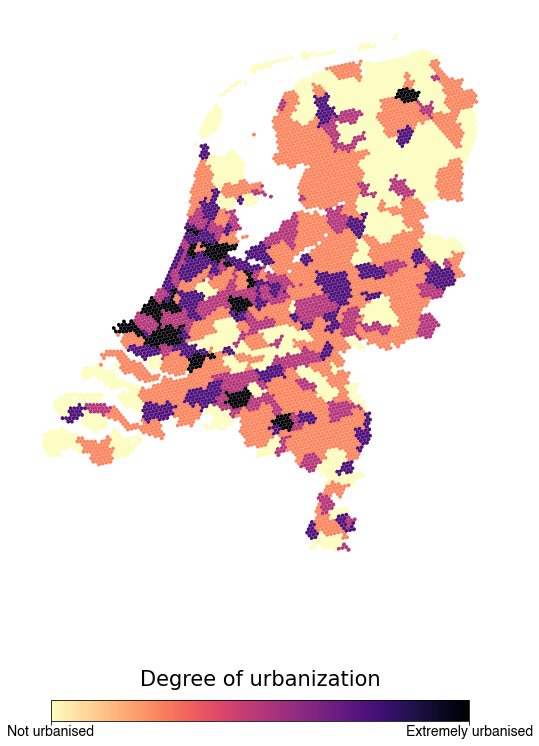

In [14]:
ax = gdf_h3.plot(figsize=(15, 15), column=var_plot, cmap=color_map,legend=True, legend_kwds={'orientation': "horizontal",'shrink': 0.5,'ticks': [-5,-1]})

ax.axis('off')

fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14,pad=0.2)

ax.set_title('Degree of urbanization',font='Arial',fontsize=21, y=-0.2)

#ax.set_title(loc='bottom')
ax.axis('off')

# Get colourbar from second axis
colourbar = ax.get_figure().get_axes()[1]

# Get numerical values of yticks, assuming a linear range between vmin and vmax:
xticks = colourbar.get_xticks()

colourbar.set_xticklabels([x if x not in dict_urb else dict_urb[x] for x in xticks])

plt.savefig('challenge_hex4.jpg',bbox_inches='tight')